In [9]:
import geopandas as gpd
import pandas as pd
import cudf
import cugraph
from tqdm import tqdm
import logging
import os
import numpy as np
from scipy.stats import pearsonr
from shapely import make_valid
from shapely.errors import GEOSException
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Ensure plots are displayed inline
%matplotlib inline

# Set the font to support Traditional Chinese
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC', 'Noto Serif CJK TC', 'Noto Sans Mono CJK TC', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


# Define file paths
BASE_DIR = "/home/johnny/Iaacthesis/projects/Geojson/GNN_Read_data"
LANDUSE_NDVI_PATH = os.path.join(BASE_DIR, "neighborhoods_with_ndvi_numerical.geojson")
OSM_BUILDINGS_PATH = os.path.join(BASE_DIR, "Taipei_Buildings_fulldata.geojson")
OSM_ROADS_PATH = os.path.join(BASE_DIR, "taipei_segments_cleaned_verified.geoparquet")
OSM_TREES_PATH = os.path.join(BASE_DIR, "taipei_land.geoparquet")
OSM_TRANSIT_PATH = os.path.join(BASE_DIR, "taipei_infrastructure.geoparquet")
URBAN_MASTERPLAN_PATH = os.path.join(BASE_DIR, "Taipei_urban_masterplan.geojson")
ACCIDENTS_PATH = os.path.join(BASE_DIR, "2023_accidents.geojson")
POPULATION_PATH = os.path.join(BASE_DIR, "population.json")
SUBGRAPH_DIR = os.path.join(BASE_DIR, "subgraphs")
CHECKPOINT_DIR = os.path.join(BASE_DIR, "checkpoints")

# Ensure directories exist
os.makedirs(SUBGRAPH_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Define category priority (higher index = higher priority)
CATEGORY_PRIORITY = {
    'City_Open_Area': 10,
    'Pedestrian': 9,
    'Public_Transportation': 8,
    'Amenity': 7,
    'Education': 6,
    'Medical': 5,
    'Commercial': 4,
    'Residential': 3,
    'Natural': 2,
    'Road': 1,
    'River': 1,
    'Infrastructure': 1,
    'Government': 1,
    'Special_Zone': 1,
    'Military': 1,
    'Industrial': 1,
    'Agriculture': 1
}

# Define land use weights for walkability scoring
land_use_weights = {
    'city_open_area': 0.8,
    'commercial': 0.7,
    'infrastructure': 0.4,
    'government': 0.5,
    'public_transportation': 0.8,
    'education': 0.7,
    'medical': 0.6,
    'amenity': 0.8,
    'road': 0.3,
    'pedestrian': 1.0,
    'natural': 0.7,
    'special_zone': 0.4,
    'river': 0.7,
    'military': 0.2,
    'residential': 0.6,
    'industrial': 0.3,
    'agriculture': 0.4
}

def print_data_structure(data_dict):
    """Print detailed structure and summary of all datasets for inspection."""
    print("\n--- Detailed Data Structure Overview ---")
    for key, df in data_dict.items():
        if isinstance(df, (gpd.GeoDataFrame, pd.DataFrame, cudf.DataFrame)):
            df = df.to_pandas() if isinstance(df, cudf.DataFrame) else df
            print(f"\nDataset: {key}")
            print(f"Shape: {df.shape}")
            print(f"Columns: {list(df.columns)}")
            print(f"Data types:\n{df.dtypes}")
            print(f"Missing values per column:\n{df.isnull().sum()}")
            if not df.select_dtypes(include=['float64', 'int64']).empty:
                summary = df.describe().round(2)
                print(f"Summary statistics for numerical columns:\n{summary}")
            print("Sample data (first 5 rows):")
            sample = df.head(5).copy()
            for col in sample.select_dtypes(include=['float64', 'int64']).columns:
                sample[col] = sample[col].round(2)
            print(sample)
    print("--- End of Detailed Data Structure Overview ---\n")

def fix_geometry(geom, buffer_size=1e-5):
    """Fix a geometry by applying make_valid and a small buffer."""
    if geom is None or geom.is_empty:
        return geom
    geom = make_valid(geom)
    if not geom.is_valid:
        geom = geom.buffer(buffer_size)
        geom = make_valid(geom)
    if not geom.is_valid:
        logging.warning(f"Geometry remains invalid after fixing: {geom.bounds}")
    return geom

def print_percentage_calculation(neighborhoods_gdf, urban_masterplan_gdf, sample_size=3):
    """Print the process of calculating land use percentages for a sample of neighborhoods with rounded numbers."""
    print("\n--- Percentage Calculation Process ---")
    sample_neighborhoods = neighborhoods_gdf.sample(min(sample_size, len(neighborhoods_gdf)), random_state=42)
    
    for idx, row in sample_neighborhoods.iterrows():
        lie_name = row['LIE_NAME']
        print(f"\nNeighborhood: {lie_name} (Index: {idx})")
        
        neighborhood_geom = fix_geometry(row['geometry'])
        if not neighborhood_geom.is_valid:
            print(f"Neighborhood geometry is invalid after fixing: {lie_name}")
            continue
        
        relevant_masterplan = urban_masterplan_gdf[urban_masterplan_gdf.intersects(neighborhood_geom)]
        if relevant_masterplan.empty:
            print("No master plan polygons intersect with this neighborhood.")
            continue
        
        temp_gdf = gpd.GeoDataFrame({'geometry': [neighborhood_geom]}, crs='EPSG:3826')
        intersected = gpd.overlay(temp_gdf, relevant_masterplan, how='intersection')
        if intersected.empty:
            print("No valid intersections after overlay.")
            continue
        
        intersected['geometry'] = intersected['geometry'].apply(fix_geometry)
        intersected = intersected[intersected.geometry.is_valid & ~intersected.geometry.is_empty]
        if intersected.empty:
            print("No valid geometries after fixing intersected polygons.")
            continue
        
        intersected['priority'] = intersected['Category'].map(CATEGORY_PRIORITY)
        intersected = intersected.sort_values(by='priority', ascending=False)
        
        total_area_geom = intersected.geometry.union_all()
        total_area_geom = fix_geometry(total_area_geom)
        if not total_area_geom.is_valid or total_area_geom.is_empty:
            print("Total area geometry is invalid after fixing.")
            continue
        total_area = total_area_geom.area
        print(f"Total unique master plan area: {total_area:.2f} m²")
        
        remaining_geom = total_area_geom
        category_areas = {}
        unique_categories = intersected['Category'].unique()
        
        for category in sorted(unique_categories, key=lambda x: CATEGORY_PRIORITY.get(x, 0), reverse=True):
            category_rows = intersected[intersected['Category'] == category]
            category_geom = category_rows.geometry.union_all()
            category_geom = fix_geometry(category_geom)
            if not category_geom.is_valid or category_geom.is_empty:
                print(f"Geometry for category {category} is invalid after fixing.")
                category_areas[category] = 0.0
                continue
            
            try:
                category_area_geom = category_geom.intersection(remaining_geom)
                category_area_geom = fix_geometry(category_area_geom)
                if not category_area_geom.is_valid or category_area_geom.is_empty:
                    print(f"Intersection geometry for category {category} is invalid after fixing.")
                    category_areas[category] = 0.0
                    continue
                
                category_area = category_area_geom.area
                category_areas[category] = category_area
                print(f"Area of {category} (priority {CATEGORY_PRIORITY.get(category, 0)}): {category_area:.2f} m²")
                
                remaining_geom = remaining_geom.difference(category_area_geom)
                remaining_geom = fix_geometry(remaining_geom)
                if not remaining_geom.is_valid or remaining_geom.is_empty:
                    print(f"Remaining geometry is invalid after subtracting {category}.")
                    break
            except GEOSException as e:
                print(f"Topology error for category {category}: {e}")
                category_areas[category] = 0.0
                continue
        
        print("\nPercentages:")
        total_percentage = 0.0
        for category, area in category_areas.items():
            percentage = (area / total_area * 100) if total_area > 0 else 0.0
            total_percentage += percentage
            print(f"{category}: {percentage:.2f}%")
        print(f"Sum of percentages: {total_percentage:.2f}%")
    print("--- End of Percentage Calculation Process ---\n")

def compute_walkability_components(neighborhoods_gdf, sample_size=5):
    """Compute the components of the walkability score for a sample of neighborhoods."""
    # Sample neighborhoods
    sample_gdf = neighborhoods_gdf.sample(min(sample_size, len(neighborhoods_gdf)), random_state=42)
    
    # Initialize lists to store components
    components = {
        'LIE_NAME': [],
        'land_use_score': [],
        'open_area_score': [],
        'ndvi_score': [],
        'tree_score': [],
        'transit_score': [],
        'road_density_score': [],
        'elderly_factor': [],
        'accident_factor': [],
        'walkability_rule': []
    }
    
    for idx, row in sample_gdf.iterrows():
        # Compute land use score
        land_use_score = 0.0
        for category, weight in land_use_weights.items():
            col_name = f"land_use_{category}_percent"
            if col_name in row:
                land_use_score += (row[col_name] * weight) / 100
        total_weight = sum(land_use_weights.values())
        if total_weight > 0:
            land_use_score = land_use_score / total_weight * 0.35  # Allocate 35% to land use
        
        # Compute other components
        # Check if the column exists, default to 0.0 if not
        open_area_percent = row.get('land_use_city_open_area_percent', 0.0)
        open_area_score = (open_area_percent / 100) * 0.15
        
        # Normalize NDVI, tree_count, transit_count, road_density, elderly_percentage, accident_count
        ndvi_min, ndvi_max = neighborhoods_gdf['ndvi_mean'].min(), neighborhoods_gdf['ndvi_mean'].max()
        tree_min, tree_max = neighborhoods_gdf['tree_count'].min(), neighborhoods_gdf['tree_count'].max()
        transit_min, transit_max = neighborhoods_gdf['transit_count'].min(), neighborhoods_gdf['transit_count'].max()
        road_density_min, road_density_max = neighborhoods_gdf['road_density'].min(), neighborhoods_gdf['road_density'].max()
        accident_min, accident_max = neighborhoods_gdf['accident_count'].min(), neighborhoods_gdf['accident_count'].max()
        
        ndvi_score = ((row['ndvi_mean'] - ndvi_min) / (ndvi_max - ndvi_min + 1e-6)) * 0.15
        tree_score = ((row['tree_count'] - tree_min) / (tree_max - tree_min + 1e-6)) * 0.1
        transit_score = ((row['transit_count'] - transit_min) / (transit_max - transit_min + 1e-6)) * 0.1
        
        # Road density score with logistic function
        road_density_normalized = (row['road_density'] - road_density_min) / (road_density_max - road_density_min + 1e-6)
        road_density_75th = neighborhoods_gdf['road_density'].quantile(0.75)
        road_density_score = 1 / (1 + np.exp(-10 * (road_density_normalized - road_density_75th / road_density_max))) * 0.1
        
        elderly_factor = (row['elderly_percentage'] / 100) * 0.1
        accident_factor = ((row['accident_count'] - accident_min) / (accident_max - accident_min + 1e-6)) * 0.1
        
        # Compute final walkability score
        walkability = (land_use_score + open_area_score + ndvi_score + tree_score + transit_score +
                       road_density_score - elderly_factor - accident_factor)
        walkability = np.clip(walkability, 0.0, 1.0)
        
        # Store components
        components['LIE_NAME'].append(row['LIE_NAME'])
        components['land_use_score'].append(land_use_score)
        components['open_area_score'].append(open_area_score)
        components['ndvi_score'].append(ndvi_score)
        components['tree_score'].append(tree_score)
        components['transit_score'].append(transit_score)
        components['road_density_score'].append(road_density_score)
        components['elderly_factor'].append(-elderly_factor)  # Negative impact
        components['accident_factor'].append(-accident_factor)  # Negative impact
        components['walkability_rule'].append(walkability)
    
    return pd.DataFrame(components)

def compute_walkability_components_all(neighborhoods_gdf):
    """Compute the components of the walkability score for all neighborhoods."""
    components = {
        'LIE_NAME': [],
        'land_use_score': [],
        'open_area_score': [],
        'ndvi_score': [],
        'tree_score': [],
        'transit_score': [],
        'road_density_score': [],
        'elderly_factor': [],
        'accident_factor': [],
        'walkability_rule': []
    }
    
    for idx, row in neighborhoods_gdf.iterrows():
        # Compute land use score
        land_use_score = 0.0
        for category, weight in land_use_weights.items():
            col_name = f"land_use_{category}_percent"
            if col_name in row:
                land_use_score += (row[col_name] * weight) / 100
        total_weight = sum(land_use_weights.values())
        if total_weight > 0:
            land_use_score = land_use_score / total_weight * 0.35  # Allocate 35% to land use
        
        # Compute other components
        # Check if the column exists, default to 0.0 if not
        open_area_percent = row.get('land_use_city_open_area_percent', 0.0)
        open_area_score = (open_area_percent / 100) * 0.15
        
        # Normalize NDVI, tree_count, transit_count, road_density, elderly_percentage, accident_count
        ndvi_min, ndvi_max = neighborhoods_gdf['ndvi_mean'].min(), neighborhoods_gdf['ndvi_mean'].max()
        tree_min, tree_max = neighborhoods_gdf['tree_count'].min(), neighborhoods_gdf['tree_count'].max()
        transit_min, transit_max = neighborhoods_gdf['transit_count'].min(), neighborhoods_gdf['transit_count'].max()
        road_density_min, road_density_max = neighborhoods_gdf['road_density'].min(), neighborhoods_gdf['road_density'].max()
        accident_min, accident_max = neighborhoods_gdf['accident_count'].min(), neighborhoods_gdf['accident_count'].max()
        
        ndvi_score = ((row['ndvi_mean'] - ndvi_min) / (ndvi_max - ndvi_min + 1e-6)) * 0.15
        tree_score = ((row['tree_count'] - tree_min) / (tree_max - tree_min + 1e-6)) * 0.1
        transit_score = ((row['transit_count'] - transit_min) / (transit_max - transit_min + 1e-6)) * 0.1
        
        # Road density score with logistic function
        road_density_normalized = (row['road_density'] - road_density_min) / (road_density_max - road_density_min + 1e-6)
        road_density_75th = neighborhoods_gdf['road_density'].quantile(0.75)
        road_density_score = 1 / (1 + np.exp(-10 * (road_density_normalized - road_density_75th / road_density_max))) * 0.1
        
        elderly_factor = (row['elderly_percentage'] / 100) * 0.1
        accident_factor = ((row['accident_count'] - accident_min) / (accident_max - accident_min + 1e-6)) * 0.1
        
        # Compute final walkability score
        walkability = (land_use_score + open_area_score + ndvi_score + tree_score + transit_score +
                       road_density_score - elderly_factor - accident_factor)
        walkability = np.clip(walkability, 0.0, 1.0)
        
        # Store components
        components['LIE_NAME'].append(row['LIE_NAME'])
        components['land_use_score'].append(land_use_score)
        components['open_area_score'].append(open_area_score)
        components['ndvi_score'].append(ndvi_score)
        components['tree_score'].append(tree_score)
        components['transit_score'].append(transit_score)
        components['road_density_score'].append(road_density_score)
        components['elderly_factor'].append(-elderly_factor)  # Negative impact
        components['accident_factor'].append(-accident_factor)  # Negative impact
        components['walkability_rule'].append(walkability)
    
    return pd.DataFrame(components)

# Compute walkability components for visualization
    logging.info("Computing walkability components for visualization...")
    walkability_components = compute_walkability_components(neighborhoods_gdf, sample_size=5)
    print("LIE_NAME values in walkability_components:", walkability_components['LIE_NAME'].tolist())

def load_and_prepare_data():
    """Load and prepare geospatial datasets, keeping geometry in geopandas."""
    logging.info("Stage 1: Loading and preparing data...")
    with tqdm(total=8, desc="Loading files") as pbar:
        neighborhoods_gdf = gpd.read_file(
            LANDUSE_NDVI_PATH,
            encoding='utf-8-sig',
            columns=['LIE_NAME', 'geometry', 'land_use_residential_percent', 'land_use_commercial_percent',
                    'land_use_education_percent', 'ndvi_mean']
        ).to_crs('EPSG:3826')
        pbar.update(1)

        buildings_gdf = gpd.read_file(OSM_BUILDINGS_PATH, columns=['geometry', 'building']).to_crs('EPSG:3826')
        buildings_gdf['area_m2'] = buildings_gdf.geometry.area
        pbar.update(1)

        roads_gdf = gpd.read_parquet(OSM_ROADS_PATH, columns=['geometry', 'class']).to_crs('EPSG:3826')
        roads_gdf['length_m'] = roads_gdf.geometry.length
        logging.info(f"Found {roads_gdf['class'].isnull().sum()} roads with missing 'class' values.")
        roads_gdf['class'] = roads_gdf['class'].fillna('unknown')
        pbar.update(1)

        trees_gdf = gpd.read_parquet(OSM_TREES_PATH, columns=['geometry', 'subtype', 'class']).to_crs('EPSG:3826')
        trees_gdf = trees_gdf[trees_gdf['subtype'] == 'tree']
        pbar.update(1)

        transit_gdf = gpd.read_parquet(OSM_TRANSIT_PATH, columns=['geometry', 'class']).to_crs('EPSG:3826')
        transit_gdf = transit_gdf[transit_gdf['class'].isin(['stop_position', 'bus_stop'])]
        pbar.update(1)

        urban_masterplan_gdf = gpd.read_file(URBAN_MASTERPLAN_PATH, columns=['geometry', 'Category']).to_crs('EPSG:3826')
        if 'area' not in urban_masterplan_gdf.columns:
            urban_masterplan_gdf['area'] = urban_masterplan_gdf.geometry.area
        pbar.update(1)

        accidents_gdf = gpd.read_file(ACCIDENTS_PATH, columns=['geometry']).to_crs('EPSG:3826')
        pbar.update(1)

        population_df = pd.read_json(POPULATION_PATH)
        population_df.rename(columns={'District': 'LIE_NAME', 'Total_Population': 'total_population',
                                      'Elderly_Percentage': 'elderly_percentage'}, inplace=True)
        pbar.update(1)

    # Validate and fix geometries
    logging.info("Validating and fixing geometries...")
    neighborhoods_gdf['geometry'] = neighborhoods_gdf['geometry'].apply(fix_geometry)
    urban_masterplan_gdf['geometry'] = urban_masterplan_gdf['geometry'].apply(fix_geometry)
    roads_gdf['geometry'] = roads_gdf['geometry'].apply(fix_geometry)
    accidents_gdf['geometry'] = accidents_gdf['geometry'].apply(fix_geometry)

    # Log invalid geometries
    invalid_neighborhoods = neighborhoods_gdf[~neighborhoods_gdf.geometry.is_valid]
    if not invalid_neighborhoods.empty:
        logging.warning(f"Found {len(invalid_neighborhoods)} invalid geometries in neighborhoods_gdf after fixing.")
    invalid_masterplan = urban_masterplan_gdf[~urban_masterplan_gdf.geometry.is_valid]
    if not invalid_masterplan.empty:
        logging.warning(f"Found {len(invalid_masterplan)} invalid geometries in urban_masterplan_gdf after fixing.")
    invalid_roads = roads_gdf[~roads_gdf.geometry.is_valid]
    if not invalid_roads.empty:
        logging.warning(f"Found {len(invalid_roads)} invalid geometries in roads_gdf after fixing.")
    invalid_accidents = accidents_gdf[~accidents_gdf.geometry.is_valid]
    if not invalid_accidents.empty:
        logging.warning(f"Found {len(invalid_accidents)} invalid geometries in accidents_gdf after fixing.")

    # Merge population data
    neighborhoods_gdf['LIE_NAME'] = neighborhoods_gdf['LIE_NAME'].str.strip().str.lower()
    population_df['LIE_NAME'] = population_df['LIE_NAME'].str.strip().str.lower()
    neighborhoods_gdf = neighborhoods_gdf.merge(
        population_df[['LIE_NAME', 'total_population', 'elderly_percentage']], on='LIE_NAME', how='left'
    )

    # Compute counts using geopandas
    for feature, gdf, col_name in [
        ('trees', trees_gdf, 'tree_count'),
        ('transit', transit_gdf, 'transit_count'),
        ('accidents', accidents_gdf, 'accident_count')
    ]:
        counts = gpd.sjoin(neighborhoods_gdf, gdf, how='left', predicate='contains')
        neighborhoods_gdf[col_name] = counts.groupby(counts.index).size().reindex(neighborhoods_gdf.index, fill_value=0)
        logging.info(f"{col_name} - Min: {neighborhoods_gdf[col_name].min()}, Max: {neighborhoods_gdf[col_name].max()}")

    # Log neighborhoods with unusually high accident counts
    high_accident_threshold = neighborhoods_gdf['accident_count'].quantile(0.95)  # Top 5%
    high_accident_neighborhoods = neighborhoods_gdf[neighborhoods_gdf['accident_count'] > high_accident_threshold]
    if not high_accident_neighborhoods.empty:
        logging.info(f"Neighborhoods with unusually high accident counts (>{high_accident_threshold}):\n{high_accident_neighborhoods[['LIE_NAME', 'accident_count']]}")

    # Compute road density (avoid double-counting by clipping roads to neighborhood boundaries)
    logging.info("Computing road density with clipping to avoid double-counting...")
    # Reset index of neighborhoods_gdf to create an explicit column for grouping
    neighborhoods_gdf = neighborhoods_gdf.reset_index().rename(columns={'index': 'neighborhood_idx'})
    clipped_roads = gpd.overlay(roads_gdf, neighborhoods_gdf, how='intersection')
    clipped_roads['length_m'] = clipped_roads.geometry.length
    # Group by the neighborhood index (neighborhood_idx) from neighborhoods_gdf
    road_lengths_grouped = clipped_roads.groupby('neighborhood_idx')['length_m'].sum()
    neighborhoods_gdf['road_length'] = road_lengths_grouped.reindex(neighborhoods_gdf.index, fill_value=0)
    neighborhoods_gdf['road_density'] = (neighborhoods_gdf['road_length'] / (neighborhoods_gdf.geometry.area / 1_000_000)).round(2)

    # Compute road type proportions per neighborhood
    logging.info("Computing road type proportions per neighborhood...")
    road_types = clipped_roads.groupby(['neighborhood_idx', 'class'])['length_m'].sum().unstack(fill_value=0)
    road_types = road_types.div(road_types.sum(axis=1), axis=0).fillna(0)
    road_types.columns = [f"road_type_{col}_proportion" for col in road_types.columns]
    neighborhoods_gdf = neighborhoods_gdf.join(road_types, on='neighborhood_idx')

    # Compute correlations and create a hexbin plot with marginal histograms
    logging.info("Computing correlations between road density, road types, and accidents...")
    corr_density_accidents, p_value_density = pearsonr(neighborhoods_gdf['road_density'], neighborhoods_gdf['accident_count'])
    logging.info(f"Correlation between road_density and accident_count: {round(corr_density_accidents, 2)} (p-value: {round(p_value_density, 2)})")

    # Create a hexbin plot with marginal histograms, manually applying logarithmic scaling
    logging.info("Generating hexbin plot for road_density vs. accident_count...")
    # Filter out zero or negative values for logarithmic scaling
    plot_data = neighborhoods_gdf[['road_density', 'accident_count']].copy()
    plot_data = plot_data[(plot_data['road_density'] > 0) & (plot_data['accident_count'] > 0)]
    if plot_data.empty:
        logging.warning("No valid data for hexbin plot after filtering zero/negative values.")
    else:
        # Create the hexbin plot without log_scale parameter
        g = sns.jointplot(
            data=plot_data,
            x='road_density',
            y='accident_count',
            kind='hex',
            color='blue',
            marginal_kws=dict(bins=50, fill=True),
            height=8
        )
        # Manually set logarithmic scales
        g.ax_joint.set_xscale('log')
        g.ax_joint.set_yscale('log')
        # Add regression line (logx=True for logarithmic x-axis)
        sns.regplot(
            data=plot_data,
            x='road_density',
            y='accident_count',
            scatter=False,
            color='red',
            ax=g.ax_joint,
            logx=True
        )
        g.set_axis_labels('Road Density (m/km², log scale)', 'Accident Count (log scale)')
        g.fig.suptitle(f'Road Density vs. Accident Count\nCorrelation: {round(corr_density_accidents, 2)} (p-value: {round(p_value_density, 2)})', y=1.05)
        plt.show()
        # Save the plot to a file
        g.savefig(os.path.join(BASE_DIR, "road_density_vs_accident_count_hexbin.png"))
        logging.info(f"Hexbin plot saved to {os.path.join(BASE_DIR, 'road_density_vs_accident_count_hexbin.png')}")

    # Select features for correlation analysis
    features_to_correlate = [
        'accident_count', 'road_density', 'ndvi_mean', 'tree_count', 'transit_count',
        'total_population', 'elderly_percentage'
    ]
    # Add road type proportions
    road_type_columns = [col for col in neighborhoods_gdf.columns if col.startswith('road_type_')]
    features_to_correlate.extend(road_type_columns)
    # Add land use percentages
    land_use_columns = [col for col in neighborhoods_gdf.columns if col.startswith('land_use_') and col.endswith('_percent')]
    features_to_correlate.extend(land_use_columns)

    # Compute correlation matrix
    corr_matrix = neighborhoods_gdf[features_to_correlate].corr()

    # Create a heatmap of correlations with accident_count
    logging.info("Generating correlation heatmap for accident_count...")
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix[['accident_count']], annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation of Features with Accident Count')
    plt.show()
    # Save the heatmap to a file
    plt.savefig(os.path.join(BASE_DIR, "correlation_heatmap.png"))
    plt.close()
    logging.info(f"Correlation heatmap saved to {os.path.join(BASE_DIR, 'correlation_heatmap.png')}")

    # Log correlations for road types
    for road_type in road_type_columns:
        corr, p_value = pearsonr(neighborhoods_gdf[road_type], neighborhoods_gdf['accident_count'])
        logging.info(f"Correlation between {road_type} and accident_count: {round(corr, 2)} (p-value: {round(p_value, 2)})")

    # Compute walkability components for visualization
    logging.info("Computing walkability components for visualization...")
    walkability_components = compute_walkability_components(neighborhoods_gdf, sample_size=5)

    # Create a stacked bar chart for walkability components
    # Create a stacked bar chart for walkability components
    logging.info("Generating stacked bar chart for walkability components...")
    font_prop = fm.FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')
    components_to_plot = [
        'land_use_score', 'open_area_score', 'ndvi_score', 'tree_score',
        'transit_score', 'road_density_score', 'elderly_factor', 'accident_factor'
    ]
    plt.figure(figsize=(12, 8))
    bottom = np.zeros(len(walkability_components))

    for component in components_to_plot:
        plt.bar(
            walkability_components['LIE_NAME'],
            walkability_components[component],
            bottom=bottom,
            label=component.replace('_', ' ').title(),
            alpha=0.8
        )
        bottom += walkability_components[component]

    plt.title('Walkability Score Components by Neighborhood', fontproperties=font_prop)
    plt.xlabel('Neighborhood', fontproperties=font_prop)
    plt.ylabel('Contribution to Walkability Score', fontproperties=font_prop)
    plt.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left', prop=font_prop)
    plt.xticks(rotation=45, fontproperties=font_prop)
    plt.tight_layout()
    plt.show()
    # Save the stacked bar chart to a file
    plt.savefig(os.path.join(BASE_DIR, "walkability_components_stacked_bar.png"))
    plt.close()
    logging.info(f"Stacked bar chart saved to {os.path.join(BASE_DIR, 'walkability_components_stacked_bar.png')}")

    # Compute walkability components for all neighborhoods for feature importance
    logging.info("Computing walkability components for all neighborhoods for feature importance...")
    walkability_components_all = compute_walkability_components_all(neighborhoods_gdf)

    # Prepare data for feature importance analysis
    features = [
        'land_use_score', 'open_area_score', 'ndvi_score', 'tree_score',
        'transit_score', 'road_density_score', 'elderly_factor', 'accident_factor'
    ]
    X = walkability_components_all[features]
    y = walkability_components_all['walkability_rule']

    # Train a Random Forest model to determine feature importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': [f.replace('_', ' ').title() for f in features],
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Create a bar plot for feature importance
    logging.info("Generating feature importance plot for walkability...")
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title('Feature Importance for Walkability Score')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    # Save the feature importance plot to a file
    plt.savefig(os.path.join(BASE_DIR, "walkability_feature_importance.png"))
    plt.close()
    logging.info(f"Feature importance plot saved to {os.path.join(BASE_DIR, 'walkability_feature_importance.png')}")

    # Compute land use percentages for all categories
    unique_categories = urban_masterplan_gdf['Category'].unique()
    skipped_neighborhoods = set()
    for idx, row in neighborhoods_gdf.iterrows():
        neighborhood_geom = fix_geometry(row['geometry'])
        if not neighborhood_geom.is_valid:
            msg = f"Skipping neighborhood {row['LIE_NAME']} (index {idx}): Invalid geometry after fixing."
            # Suppress this specific message
            if "Skipping neighborhood" not in msg:
                logging.warning(msg)
            skipped_neighborhoods.add(row['LIE_NAME'])
            continue
        
        relevant_masterplan = urban_masterplan_gdf[urban_masterplan_gdf.intersects(neighborhood_geom)]
        if relevant_masterplan.empty:
            continue
        
        temp_gdf = gpd.GeoDataFrame({'geometry': [neighborhood_geom]}, crs='EPSG:3826')
        intersected = gpd.overlay(temp_gdf, relevant_masterplan, how='intersection')
        if intersected.empty:
            continue
        
        intersected['geometry'] = intersected['geometry'].apply(fix_geometry)
        intersected = intersected[intersected.geometry.is_valid & ~intersected.geometry.is_empty]
        if intersected.empty:
            msg = f"Skipping neighborhood {row['LIE_NAME']} (index {idx}): No valid intersected geometries."
            # Suppress this specific message
            if "Skipping neighborhood" not in msg:
                logging.warning(msg)
            skipped_neighborhoods.add(row['LIE_NAME'])
            continue
        
        intersected['priority'] = intersected['Category'].map(CATEGORY_PRIORITY)
        intersected = intersected.sort_values(by='priority', ascending=False)
        
        total_area_geom = intersected.geometry.union_all()
        total_area_geom = fix_geometry(total_area_geom)
        if not total_area_geom.is_valid or total_area_geom.is_empty:
            msg = f"Skipping neighborhood {row['LIE_NAME']} (index {idx}): Invalid total area geometry."
            # Suppress this specific message
            if "Skipping neighborhood" not in msg:
                logging.warning(msg)
            skipped_neighborhoods.add(row['LIE_NAME'])
            continue
        total_area = total_area_geom.area
        
        remaining_geom = total_area_geom
        failed_categories = 0
        for category in sorted(unique_categories, key=lambda x: CATEGORY_PRIORITY.get(x, 0), reverse=True):
            category_rows = intersected[intersected['Category'] == category]
            category_geom = category_rows.geometry.union_all()
            category_geom = fix_geometry(category_geom)
            if not category_geom.is_valid or category_geom.is_empty:
                msg = f"Skipping category {category} in neighborhood {row['LIE_NAME']} (index {idx}): Invalid category geometry."
                # Suppress this specific message
                if "Skipping category" not in msg:
                    logging.warning(msg)
                failed_categories += 1
                if failed_categories > len(unique_categories) / 2:
                    msg = f"Skipping neighborhood {row['LIE_NAME']} (index {idx}): Too many invalid categories."
                    # Suppress this specific message
                    if "Skipping neighborhood" not in msg:
                        logging.warning(msg)
                    skipped_neighborhoods.add(row['LIE_NAME'])
                    break
                continue
            
            try:
                category_area_geom = category_geom.intersection(remaining_geom)
                category_area_geom = fix_geometry(category_area_geom)
                if not category_area_geom.is_valid or category_area_geom.is_empty:
                    msg = f"Skipping category {category} in neighborhood {row['LIE_NAME']} (index {idx}): Invalid intersection geometry."
                    # Suppress this specific message
                    if "Skipping category" not in msg:
                        logging.warning(msg)
                    failed_categories += 1
                    if failed_categories > len(unique_categories) / 2:
                        msg = f"Skipping neighborhood {row['LIE_NAME']} (index {idx}): Too many invalid categories."
                        # Suppress this specific message
                        if "Skipping neighborhood" not in msg:
                            logging.warning(msg)
                        skipped_neighborhoods.add(row['LIE_NAME'])
                        break
                    continue
                
                category_area = category_area_geom.area
                column_name = f"land_use_{category.lower()}_percent"
                percentage = (category_area / total_area * 100) if total_area > 0 else 0.0
                neighborhoods_gdf.at[idx, column_name] = round(percentage, 2)
                
                remaining_geom = remaining_geom.difference(category_area_geom)
                remaining_geom = fix_geometry(remaining_geom)
                if not remaining_geom.is_valid or remaining_geom.is_empty:
                    msg = f"Remaining geometry invalid after subtracting {category} in neighborhood {row['LIE_NAME']} (index {idx})."
                    # Suppress this specific message if needed
                    if "Skipping" not in msg:
                        logging.warning(msg)
                    break
            except GEOSException as e:
                msg = f"Topology error for category {category} in neighborhood {row['LIE_NAME']} (index {idx}): {e}"
                # Suppress this specific message
                if "Topology error" not in msg:
                    logging.warning(msg)
                failed_categories += 1
                if failed_categories > len(unique_categories) / 2:
                    msg = f"Skipping neighborhood {row['LIE_NAME']} (index {idx}): Too many invalid categories."
                    # Suppress this specific message
                    if "Skipping neighborhood" not in msg:
                        logging.warning(msg)
                    skipped_neighborhoods.add(row['LIE_NAME'])
                    break
                continue

    # Log the list of skipped neighborhoods
    if skipped_neighborhoods:
        logging.warning(f"Skipped the following neighborhoods due to geometry issues: {', '.join(sorted(skipped_neighborhoods))}")

    # Ensure all land use columns are filled with 0.0 if NaN
    for category in unique_categories:
        column_name = f"land_use_{category.lower()}_percent"
        neighborhoods_gdf[column_name] = neighborhoods_gdf[column_name].fillna(0.0)

    # Print the percentage calculation process for a sample of neighborhoods
    print_percentage_calculation(neighborhoods_gdf, urban_masterplan_gdf, sample_size=3)

    # Compute correlation between city_open_area_percent and ndvi_mean
    if 'land_use_city_open_area_percent' in neighborhoods_gdf.columns:
        correlation, p_value = pearsonr(neighborhoods_gdf['land_use_city_open_area_percent'], neighborhoods_gdf['ndvi_mean'])
        logging.info(f"Correlation between city_open_area_percent and ndvi_mean: {round(correlation, 2)} (p-value: {round(p_value, 2)})")

    # Keep GeoDataFrames as-is for spatial data, convert numerical data later
    data_dict = {
        'neighborhoods': neighborhoods_gdf,
        'buildings': buildings_gdf,
        'roads': roads_gdf,
        'trees': trees_gdf,
        'transit': transit_gdf,
        'urban_masterplan': urban_masterplan_gdf,
        'accidents': accidents_gdf,
        'population': population_df
    }
    print_data_structure(data_dict)
    return data_dict

In [10]:
import cugraph
import cudf
import pandas as pd
import os
from tqdm import tqdm
import pickle
from shapely.geometry import Point
import numpy as np

def build_graph(data):
    """Build a city-wide graph using cugraph with GPU acceleration."""
    logging.info("Stage 2: Building graph network...")
    G = cugraph.Graph(directed=False)
    target_crs = 'EPSG:3826'

    # Extract GeoDataFrames
    neighborhoods_gdf = data['neighborhoods']
    buildings_gdf = data['buildings']
    roads_gdf = data['roads']
    trees_gdf = data['trees']
    transit_gdf = data['transit']
    accidents_gdf = data['accidents']

    # Compute accident counts per road and retain in roads_pd
    logging.info("Computing accident counts per road...")
    roads_pd = roads_gdf.copy()
    road_accidents = gpd.sjoin(roads_pd, accidents_gdf, how='left', predicate='intersects')
    roads_pd['accident_count'] = road_accidents.groupby(road_accidents.index).size().reindex(roads_pd.index, fill_value=0)

    # Build nodes and edges
    all_nodes = []
    all_edges = []
    node_id_to_index = {}  # Map string node IDs to integer indices
    current_index = 0  # Counter for assigning indices

    # Neighborhood nodes
    for idx, row in neighborhoods_gdf.iterrows():
        node_id = f"neighborhood_{row['LIE_NAME']}"
        node_id_to_index[node_id] = current_index  # Assign an index to the node ID
        # Include all land use percentages dynamically
        node_data = {
            'vertex': node_id,
            'index': current_index,  # Store the integer index
            'type': 'neighborhood',
            'LIE_NAME': row['LIE_NAME'],
            'ndvi_mean': float(row['ndvi_mean']),
            'tree_count': int(row['tree_count']),
            'transit_count': int(row['transit_count']),
            'accident_count': int(row['accident_count']),
            'road_density': float(row['road_density']),
            'total_population': float(row['total_population']),
            'elderly_percentage': float(row['elderly_percentage'])
        }
        # Add all land use percentage columns
        for col in neighborhoods_gdf.columns:
            if col.startswith('land_use_') and col.endswith('_percent'):
                node_data[col] = float(row[col])
        all_nodes.append(node_data)
        current_index += 1

        # Buffer for spatial relationships
        buffer = row['geometry'].buffer(200)
        relevant_buildings = buildings_gdf[buildings_gdf.geometry.within(buffer)]
        relevant_roads = roads_pd[roads_pd.geometry.intersects(buffer)]
        relevant_trees = trees_gdf[trees_gdf.geometry.within(buffer)]
        relevant_transit = transit_gdf[transit_gdf.geometry.within(buffer)]

        # Building nodes and edges
        for b_idx, b_row in relevant_buildings.iterrows():
            b_id = f"building_{b_idx}"
            if b_id not in node_id_to_index:
                node_id_to_index[b_id] = current_index
                all_nodes.append({
                    'vertex': b_id,
                    'index': current_index,
                    'type': 'building',
                    'area_m2': float(b_row['area_m2']),
                    'building_type': b_row['building']
                })
                current_index += 1
            distance = row['geometry'].distance(b_row['geometry'])
            if distance < 100:
                all_edges.append({'src': node_id, 'dst': b_id, 'weight': distance})

        # Road nodes and edges
        for r_idx, r_row in relevant_roads.iterrows():
            geom = r_row['geometry']
            if geom.geom_type == 'LineString':
                start_id = f"road_start_{r_idx}"
                end_id = f"road_end_{r_idx}"
                if start_id not in node_id_to_index:
                    node_id_to_index[start_id] = current_index
                    all_nodes.append({
                        'vertex': start_id,
                        'index': current_index,
                        'type': 'road',
                        'road_class': r_row['class'],
                        'length_m': float(r_row['length_m']),
                        'accident_count': int(r_row.get('accident_count', 0))
                    })
                    current_index += 1
                if end_id not in node_id_to_index:
                    node_id_to_index[end_id] = current_index
                    all_nodes.append({
                        'vertex': end_id,
                        'index': current_index,
                        'type': 'road',
                        'road_class': r_row['class'],
                        'length_m': float(r_row['length_m']),
                        'accident_count': int(r_row.get('accident_count', 0))
                    })
                    current_index += 1
                distance = row['geometry'].distance(Point(geom.coords[0]))
                all_edges.append({'src': node_id, 'dst': start_id, 'weight': distance})
                distance = row['geometry'].distance(Point(geom.coords[-1]))
                all_edges.append({'src': node_id, 'dst': end_id, 'weight': distance})

        # Tree and transit nodes
        for t_idx, t_row in relevant_trees.iterrows():
            t_id = f"tree_{t_idx}"
            if t_id not in node_id_to_index:
                node_id_to_index[t_id] = current_index
                all_nodes.append({
                    'vertex': t_id,
                    'index': current_index,
                    'type': 'tree'
                })
                current_index += 1
            distance = row['geometry'].distance(t_row['geometry'])
            all_edges.append({'src': node_id, 'dst': t_id, 'weight': distance})

        for tr_idx, tr_row in relevant_transit.iterrows():
            tr_id = f"transit_{tr_idx}"
            if tr_id not in node_id_to_index:
                node_id_to_index[tr_id] = current_index
                all_nodes.append({
                    'vertex': tr_id,
                    'index': current_index,
                    'type': 'transit',
                    'class': tr_row['class']
                })
                current_index += 1
            distance = row['geometry'].distance(tr_row['geometry'])
            all_edges.append({'src': node_id, 'dst': tr_id, 'weight': distance})

    # Convert to cudf and build cugraph
    nodes_df = cudf.DataFrame(all_nodes)
    edges_df = cudf.DataFrame(all_edges)
    G.from_cudf_edgelist(edges_df, source='src', destination='dst', edge_attr='weight')
    G._nodes = nodes_df
    G._edges = edges_df  # Store edges for use in prepare_gnn_data
    G._node_id_to_index = node_id_to_index  # Store the mapping for later use

    logging.info(f"City graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

In [11]:
import torch
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from tqdm import tqdm
import logging
import os
import numpy as np
import cudf

# Define land use weights for walkability scoring (already defined in Cell 1, but repeated here for clarity)
land_use_weights = {
    'city_open_area': 0.8,
    'commercial': 0.7,
    'infrastructure': 0.4,
    'government': 0.5,
    'public_transportation': 0.8,
    'education': 0.7,
    'medical': 0.6,
    'amenity': 0.8,
    'road': 0.3,
    'pedestrian': 1.0,
    'natural': 0.7,
    'special_zone': 0.4,
    'river': 0.7,
    'military': 0.2,
    'residential': 0.6,
    'industrial': 0.3,
    'agriculture': 0.4
}

def compute_walkability_scores(G):
    """Compute rule-based walkability scores using GPU-accelerated data."""
    logging.info("Stage 3: Calculating rule-based walkability scores...")
    nodes_df = G._nodes

    # Create the neighborhood mask and filter
    neighborhood_mask = nodes_df['type'] == 'neighborhood'
    neighborhood_df = nodes_df[neighborhood_mask].copy()

    if len(neighborhood_df) == 0:
        logging.warning("No neighborhood nodes found.")
        nodes_df['walkability_rule'] = 0.0
        G._nodes = nodes_df
        return G

    # Compute land use score using all categories
    land_use_score = 0.0
    for category, weight in land_use_weights.items():
        col_name = f"land_use_{category}_percent"
        if col_name in neighborhood_df.columns:
            land_use_score += (neighborhood_df[col_name].fillna(0.0) * weight) / 100
        else:
            logging.warning(f"Column {col_name} not found in neighborhood_df.")

    total_weight = sum(land_use_weights.values())
    if total_weight > 0:
        land_use_score = land_use_score / total_weight * 0.35  # Allocate 35% to land use

    open_area_score = (neighborhood_df['land_use_city_open_area_percent'].fillna(0.0) / 100) * 0.15

    # Normalize NDVI, tree_count, transit_count, road_density, elderly_percentage, accident_count
    ndvi_min, ndvi_max = neighborhood_df['ndvi_mean'].min(), neighborhood_df['ndvi_mean'].max()
    tree_min, tree_max = neighborhood_df['tree_count'].min(), neighborhood_df['tree_count'].max()
    transit_min, transit_max = neighborhood_df['transit_count'].min(), neighborhood_df['transit_count'].max()
    road_density_min, road_density_max = neighborhood_df['road_density'].min(), neighborhood_df['road_density'].max()
    accident_min, accident_max = neighborhood_df['accident_count'].min(), neighborhood_df['accident_count'].max()

    ndvi_score = ((neighborhood_df['ndvi_mean'] - ndvi_min) / (ndvi_max - ndvi_min + 1e-6)) * 0.15
    tree_score = ((neighborhood_df['tree_count'] - tree_min) / (tree_max - tree_min + 1e-6)) * 0.1
    transit_score = ((neighborhood_df['transit_count'] - transit_min) / (transit_max - transit_min + 1e-6)) * 0.1

    # Road density score with logistic function
    road_density_normalized = (neighborhood_df['road_density'] - road_density_min) / (road_density_max - road_density_min + 1e-6)
    road_density_75th = neighborhood_df['road_density'].quantile(0.75)
    road_density_score = 1 / (1 + np.exp(-10 * (road_density_normalized - road_density_75th / road_density_max))) * 0.1

    elderly_factor = (neighborhood_df['elderly_percentage'].fillna(0.0) / 100) * 0.1
    accident_factor = ((neighborhood_df['accident_count'] - accident_min) / (accident_max - accident_min + 1e-6)) * 0.1

    # Compute final walkability score
    walkability = (land_use_score + open_area_score + ndvi_score + tree_score + transit_score +
                   road_density_score - elderly_factor - accident_factor)
    walkability = walkability.clip(0.0, 1.0)

    # Assign walkability scores back to the nodes
    neighborhood_df['walkability_rule'] = walkability

    # Convert to pandas for assignment to handle non-unique indices
    nodes_df_pandas = nodes_df.to_pandas()
    neighborhood_df_pandas = neighborhood_df.to_pandas()
    nodes_df_pandas.loc[neighborhood_mask.to_pandas(), 'walkability_rule'] = neighborhood_df_pandas['walkability_rule']
    nodes_df = cudf.from_pandas(nodes_df_pandas)

    # Ensure non-neighborhood nodes have a default value
    nodes_df['walkability_rule'] = nodes_df['walkability_rule'].fillna(0.0)
    G._nodes = nodes_df

    return G

def prepare_gnn_data(G):
    """Prepare data for GNN training using PyTorch Geometric."""
    logging.info("Preparing GNN data...")
    nodes_df = G._nodes
    edges_df = G._edges
    node_id_to_index = G._node_id_to_index  # Get the mapping

    # Feature columns for GNN
    feature_cols = [
        'land_use_residential_percent', 'land_use_commercial_percent', 'land_use_education_percent',
        'land_use_city_open_area_percent', 'land_use_public_transportation_percent', 'land_use_pedestrian_percent',
        'ndvi_mean', 'tree_count', 'transit_count', 'accident_count', 'road_density',
        'total_population', 'elderly_percentage'
    ]

    # Ensure all feature columns exist and fill NaNs
    for col in feature_cols:
        if col not in nodes_df.columns:
            nodes_df[col] = 0.0
        nodes_df[col] = nodes_df[col].fillna(0.0)

    logging.info(f"Number of nodes in nodes_df: {len(nodes_df)}")
    logging.info(f"Feature columns: {feature_cols}")
    logging.info(f"Shape of nodes_df[feature_cols]: {nodes_df[feature_cols].shape}")

    # Convert features to tensor
    x = torch.tensor(nodes_df[feature_cols].to_pandas().values, dtype=torch.float)
    logging.info(f"Shape of input tensor x: {x.shape}")

    # Map string node IDs to integer indices for edges
    src_indices = edges_df['src'].to_pandas().map(node_id_to_index).values
    dst_indices = edges_df['dst'].to_pandas().map(node_id_to_index).values

    # Convert edges to tensor
    edge_index = torch.tensor(
        [src_indices, dst_indices],
        dtype=torch.long
    )

    # Labels (walkability_rule)
    y = torch.tensor(nodes_df['walkability_rule'].to_pandas().values, dtype=torch.float)

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

class WalkabilityGNN(torch.nn.Module):
    """Graph Attention Network (GAT) for walkability prediction."""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(WalkabilityGNN, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.nn.functional.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

def train_gnn_model(data_gnn):
    """Train the GNN model using PyTorch Geometric."""
    logging.info("Stage 4: Training GNN model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = WalkabilityGNN(
        in_channels=data_gnn.x.shape[1],
        hidden_channels=16,
        out_channels=1,
        heads=4
    ).to(device)
    data_gnn = data_gnn.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.MSELoss()

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data_gnn).squeeze()
        loss = criterion(out, data_gnn.y)
        loss.backward()
        optimizer.step()
        logging.info(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    logging.info("Training completed.")
    return model

def predict_walkability(G, model):
    """Predict walkability scores using the trained GNN model."""
    logging.info("Predicting walkability with GNN...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Prepare data for prediction
    data_gnn = prepare_gnn_data(G)
    data_gnn = data_gnn.to(device)

    with torch.no_grad():
        pred = model(data_gnn).squeeze().cpu().numpy()

    # Assign predictions back to nodes
    nodes_df = G._nodes
    nodes_df['walkability_gnn'] = pred
    nodes_df['walkability_gnn'] = nodes_df['walkability_gnn'].clip(0.0, 1.0)
    G._nodes = nodes_df
    return G

In [12]:
import json
import os
import webbrowser
from keplergl import KeplerGl
import pandas as pd
import geopandas as gpd

CONFIG_PATH = os.path.join(BASE_DIR, "kepler.gl.json")
TEMP_HTML_PATH = os.path.join(BASE_DIR, "temp_map.html")
MAPBOX_ACCESS_TOKEN = "your_mapbox_token_here"  # Replace with your Mapbox token

def create_interactive_map(G, data):
    """Generate an interactive Kepler.gl map with all datasets and generated results."""
    logging.info("Generating interactive Kepler.gl map...")

    # Convert all GeoDataFrames to WGS84 (EPSG:4326) for Kepler.gl
    neighborhoods_gdf = data['neighborhoods'].to_crs('EPSG:4326')
    buildings_gdf = data['buildings'].to_crs('EPSG:4326')
    roads_gdf = data['roads'].to_crs('EPSG:4326')
    trees_gdf = data['trees'].to_crs('EPSG:4326')
    transit_gdf = data['transit'].to_crs('EPSG:4326')
    urban_masterplan_gdf = data['urban_masterplan'].to_crs('EPSG:4326')
    accidents_gdf = data['accidents'].to_crs('EPSG:4326')

    # Update neighborhoods with walkability scores from G
    nodes_df = G._nodes.to_pandas()
    neighborhood_nodes = nodes_df[nodes_df['type'] == 'neighborhood']
    for _, row in neighborhood_nodes.iterrows():
        lie_name = row['LIE_NAME']
        walkability_rule = round(row['walkability_rule'], 2) if pd.notna(row['walkability_rule']) else 0.0
        walkability_gnn = round(row['walkability_gnn'], 2) if pd.notna(row['walkability_gnn']) else 0.0
        neighborhoods_gdf.loc[neighborhoods_gdf['LIE_NAME'] == lie_name, 'walkability_rule'] = walkability_rule
        neighborhoods_gdf.loc[neighborhoods_gdf['LIE_NAME'] == lie_name, 'walkability_gnn'] = walkability_gnn

    # Update roads with accident counts from build_graph
    roads_pd = roads_gdf.copy()
    road_accidents = gpd.sjoin(roads_pd, accidents_gdf, how='left', predicate='intersects')
    roads_pd['accident_count'] = road_accidents.groupby(road_accidents.index).size().reindex(roads_pd.index, fill_value=0)

    # Prepare GeoJSON for each dataset
    neighborhoods_data = {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'properties': {
                    'LIE_NAME': row['LIE_NAME'],
                    'walkability_rule': row['walkability_rule'],
                    'walkability_gnn': row['walkability_gnn'],
                    'city_open_area_percent': float(row['land_use_city_open_area_percent']),
                    'tree_count': int(row['tree_count']),
                    'transit_count': int(row['transit_count']),
                    'accident_count': int(row['accident_count']),
                    'ndvi_mean': float(row['ndvi_mean']),
                    'road_density': float(row['road_density']),
                    'total_population': int(row['total_population']),
                    'elderly_percentage': float(row['elderly_percentage'])
                },
                'geometry': row['geometry'].__geo_interface__
            }
            for _, row in neighborhoods_gdf.iterrows() if row['geometry'] is not None
        ]
    }

    buildings_data = {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'properties': {
                    'building': row['building'],
                    'area_m2': float(row['area_m2'])
                },
                'geometry': row['geometry'].__geo_interface__
            }
            for _, row in buildings_gdf.iterrows() if row['geometry'] is not None
        ]
    }

    roads_data = {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'properties': {
                    'class': row['class'],
                    'length_m': float(row['length_m']),
                    'accident_count': int(row['accident_count'])
                },
                'geometry': row['geometry'].__geo_interface__
            }
            for _, row in roads_pd.iterrows() if row['geometry'] is not None
        ]
    }

    trees_data = {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'properties': {
                    'subtype': row['subtype'],
                    'class': row['class']
                },
                'geometry': row['geometry'].__geo_interface__
            }
            for _, row in trees_gdf.iterrows() if row['geometry'] is not None
        ]
    }

    transit_data = {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'properties': {
                    'class': row['class']
                },
                'geometry': row['geometry'].__geo_interface__
            }
            for _, row in transit_gdf.iterrows() if row['geometry'] is not None
        ]
    }

    urban_masterplan_data = {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'properties': {
                    'Category': row['Category']
                },
                'geometry': row['geometry'].__geo_interface__
            }
            for _, row in urban_masterplan_gdf.iterrows() if row['geometry'] is not None
        ]
    }

    accidents_data = {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'properties': {},
                'geometry': row['geometry'].__geo_interface__
            }
            for _, row in accidents_gdf.iterrows() if row['geometry'] is not None
        ]
    }

    # Initialize Kepler.gl map
    map_1 = KeplerGl(height=600, width=800, mapbox_api_access_token=MAPBOX_ACCESS_TOKEN)

    # Add all datasets to the map
    map_1.add_data(data=neighborhoods_data, name="Neighborhoods")
    map_1.add_data(data=buildings_data, name="Buildings")
    map_1.add_data(data=roads_data, name="Roads")
    map_1.add_data(data=trees_data, name="Trees")
    map_1.add_data(data=transit_data, name="Transit")
    map_1.add_data(data=urban_masterplan_data, name="Urban_Masterplan")
    map_1.add_data(data=accidents_data, name="Accidents")

    # Load or create configuration
    if not os.path.exists(CONFIG_PATH):
        logging.info("No saved configuration found. Generating a temporary HTML for customization...")
        map_1.save_to_html(file_name=TEMP_HTML_PATH)
        webbrowser.open(f"file://{os.path.abspath(TEMP_HTML_PATH)}")
        input("Press Enter after saving kepler.gl.json, or Ctrl+C to cancel.")
        if not os.path.exists(CONFIG_PATH):
            raise FileNotFoundError(f"Configuration file {CONFIG_PATH} not found.")

    with open(CONFIG_PATH, 'r') as f:
        custom_config = json.load(f)

    # Customize layer styles
    for layer in custom_config['config']['visState']['layers']:
        if layer['config']['dataId'] == "Neighborhoods":
            layer['config']['columns'] = {'geojson': 'geometry'}
            layer['visualChannels']['colorField'] = {'name': 'walkability_gnn', 'type': 'real'}
            layer['visualChannels']['colorScale'] = 'quantile'
            layer['config']['visConfig']['colorRange'] = {
                'name': 'Global Warming',
                'type': 'sequential',
                'category': 'Uber',
                'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']
            }
            layer['config']['visConfig']['opacity'] = 0.8
            layer['config']['isVisible'] = True
        elif layer['config']['dataId'] == "Buildings":
            layer['config']['columns'] = {'geojson': 'geometry'}
            layer['visualChannels']['colorField'] = {'name': 'area_m2', 'type': 'real'}
            layer['visualChannels']['colorScale'] = 'quantile'
            layer['config']['visConfig']['colorRange'] = {
                'name': 'Blue Teal',
                'type': 'sequential',
                'category': 'Uber',
                'colors': ['#D3F2F7', '#A2D6E3', '#71B9CF', '#409CBB', '#0F7FA7']
            }
            layer['config']['visConfig']['opacity'] = 0.6
            layer['config']['isVisible'] = True
        elif layer['config']['dataId'] == "Roads":
            layer['config']['columns'] = {'geojson': 'geometry'}
            layer['visualChannels']['colorField'] = {'name': 'accident_count', 'type': 'integer'}
            layer['visualChannels']['colorScale'] = 'quantile'
            layer['config']['visConfig']['colorRange'] = {
                'name': 'Red',
                'type': 'sequential',
                'category': 'Uber',
                'colors': ['#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C']
            }
            layer['config']['visConfig']['opacity'] = 0.7
            layer['config']['visConfig']['thickness'] = 0.5
            layer['config']['isVisible'] = True
        elif layer['config']['dataId'] == "Trees":
            layer['config']['columns'] = {'geojson': 'geometry'}
            layer['config']['visConfig']['color'] = [34, 139, 34]  # Forest Green
            layer['config']['visConfig']['radius'] = 5
            layer['config']['isVisible'] = True
        elif layer['config']['dataId'] == "Transit":
            layer['config']['columns'] = {'geojson': 'geometry'}
            layer['config']['visConfig']['color'] = [0, 0, 255]  # Blue
            layer['config']['visConfig']['radius'] = 5
            layer['config']['isVisible'] = True
        elif layer['config']['dataId'] == "Urban_Masterplan":
            layer['config']['columns'] = {'geojson': 'geometry'}
            layer['visualChannels']['colorField'] = {'name': 'Category', 'type': 'string'}
            layer['visualChannels']['colorScale'] = 'ordinal'
            layer['config']['visConfig']['opacity'] = 0.5
            layer['config']['isVisible'] = True
        elif layer['config']['dataId'] == "Accidents":
            layer['config']['columns'] = {'geojson': 'geometry'}
            layer['config']['visConfig']['color'] = [255, 0, 0]  # Red
            layer['config']['visConfig']['radius'] = 3
            layer['config']['isVisible'] = True

    # Re-initialize map with custom configuration
    map_1 = KeplerGl(height=600, width=800, mapbox_api_access_token=MAPBOX_ACCESS_TOKEN, config=custom_config)
    map_1.add_data(data=neighborhoods_data, name="Neighborhoods")
    map_1.add_data(data=buildings_data, name="Buildings")
    map_1.add_data(data=roads_data, name="Roads")
    map_1.add_data(data=trees_data, name="Trees")
    map_1.add_data(data=transit_data, name="Transit")
    map_1.add_data(data=urban_masterplan_data, name="Urban_Masterplan")
    map_1.add_data(data=accidents_data, name="Accidents")

    output_path = os.path.join(BASE_DIR, "walkability_map.html")
    map_1.save_to_html(file_name=output_path)
    logging.info(f"Map saved at {output_path}")
    if os.path.exists(TEMP_HTML_PATH):
        os.remove(TEMP_HTML_PATH)

2025-04-13 14:37:45,772 - INFO - Ensured subgraph directory exists: /home/johnny/Iaacthesis/projects/Geojson/GNN_Read_data/subgraphs
2025-04-13 14:37:45,772 - INFO - Stage 1: Loading and preparing data...


Starting load_and_prepare_data...


Loading files: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]
2025-04-13 14:37:48,480 - INFO - Validating and fixing geometries...
2025-04-13 14:37:50,781 - INFO - tree_count - Min: 1, Max: 211
2025-04-13 14:37:50,790 - INFO - transit_count - Min: 1, Max: 81
2025-04-13 14:37:50,817 - INFO - accident_count - Min: 1, Max: 806
2025-04-13 14:37:50,820 - INFO - Neighborhoods with unusually high accident counts (>299.5499999999995):
    LIE_NAME  accident_count
20       一德里             341
34       八仙里             534
68       建民里             310
79       福林里             442
83       後港里             373
117      港墘里             422
138      湖元里             806
150      集英里             377
156      石潭里             343
171      民權里             374
220      玉泉里             510
225      正得里             314
236      光復里             336
241      福星里             368
242      黎明里             683
244      新仁里             447
256      梅花里             475
265      民輝里             313
277      興雅里       

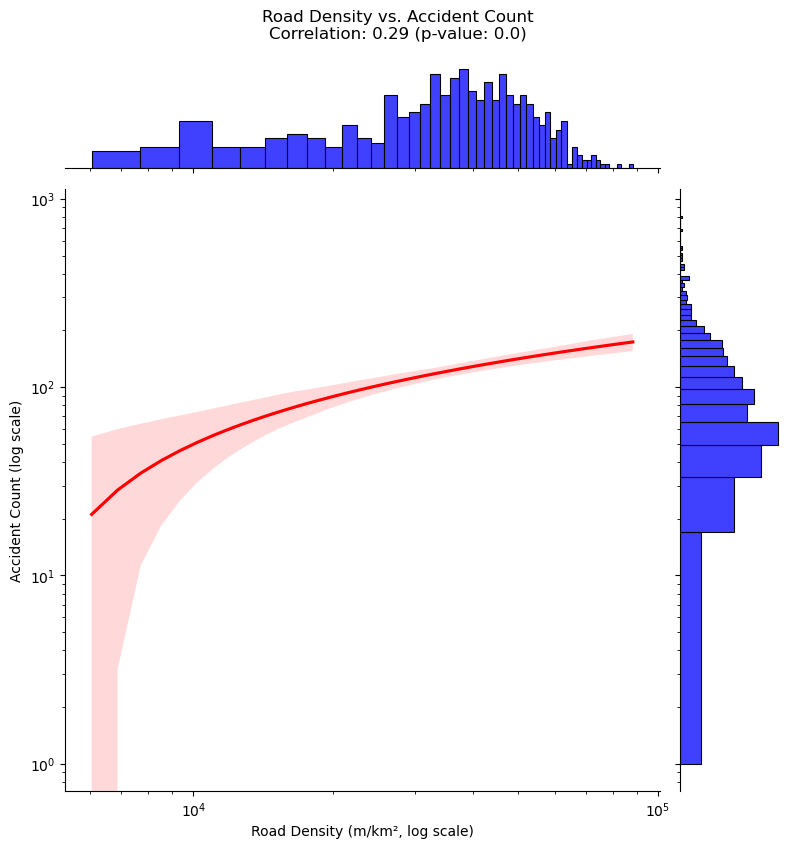

2025-04-13 14:37:52,814 - INFO - Hexbin plot saved to /home/johnny/Iaacthesis/projects/Geojson/GNN_Read_data/road_density_vs_accident_count_hexbin.png
2025-04-13 14:37:52,816 - INFO - Generating correlation heatmap for accident_count...


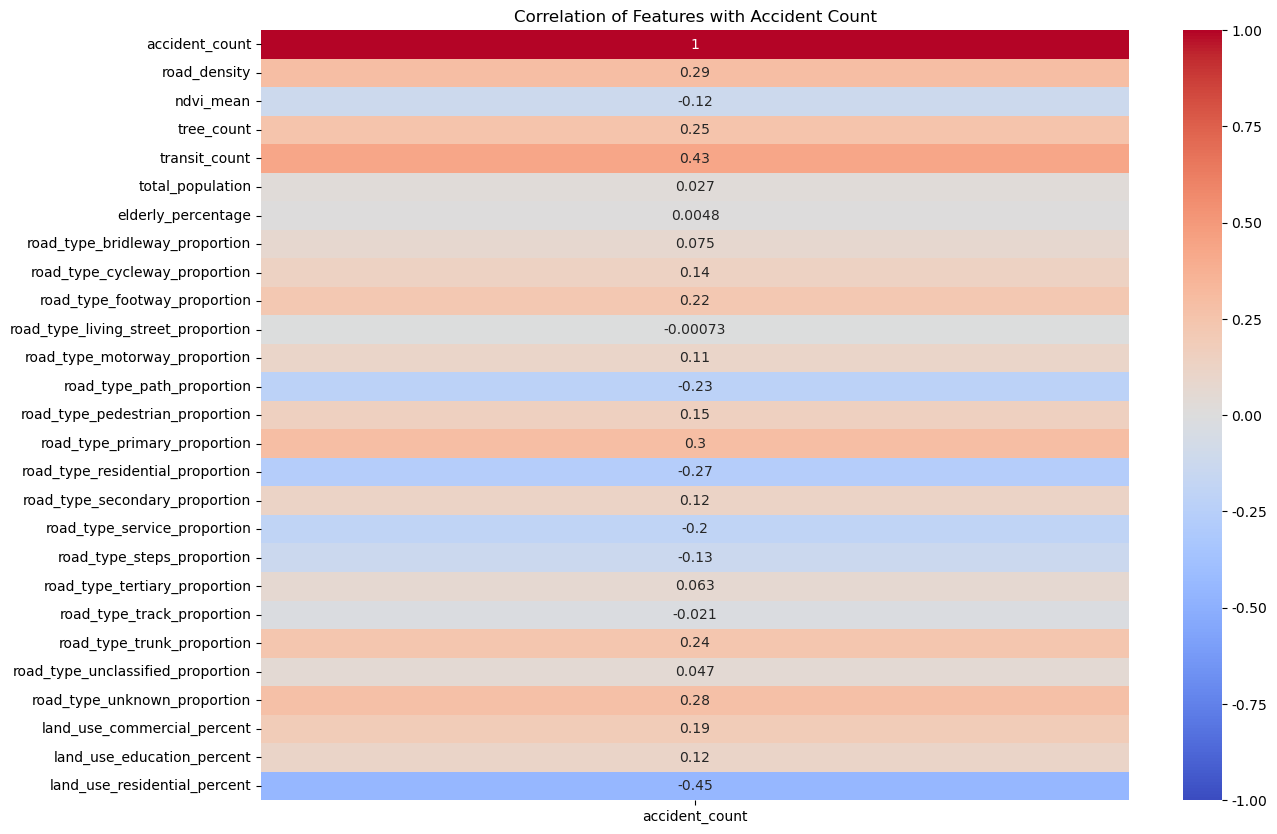

2025-04-13 14:37:53,005 - INFO - Correlation heatmap saved to /home/johnny/Iaacthesis/projects/Geojson/GNN_Read_data/correlation_heatmap.png
2025-04-13 14:37:53,006 - INFO - Correlation between road_type_bridleway_proportion and accident_count: 0.07 (p-value: 0.11)
2025-04-13 14:37:53,008 - INFO - Correlation between road_type_cycleway_proportion and accident_count: 0.14 (p-value: 0.0)
2025-04-13 14:37:53,009 - INFO - Correlation between road_type_footway_proportion and accident_count: 0.22 (p-value: 0.0)
2025-04-13 14:37:53,010 - INFO - Correlation between road_type_living_street_proportion and accident_count: -0.0 (p-value: 0.99)
2025-04-13 14:37:53,011 - INFO - Correlation between road_type_motorway_proportion and accident_count: 0.11 (p-value: 0.02)
2025-04-13 14:37:53,012 - INFO - Correlation between road_type_path_proportion and accident_count: -0.23 (p-value: 0.0)
2025-04-13 14:37:53,014 - INFO - Correlation between road_type_pedestrian_proportion and accident_count: 0.15 (p-val

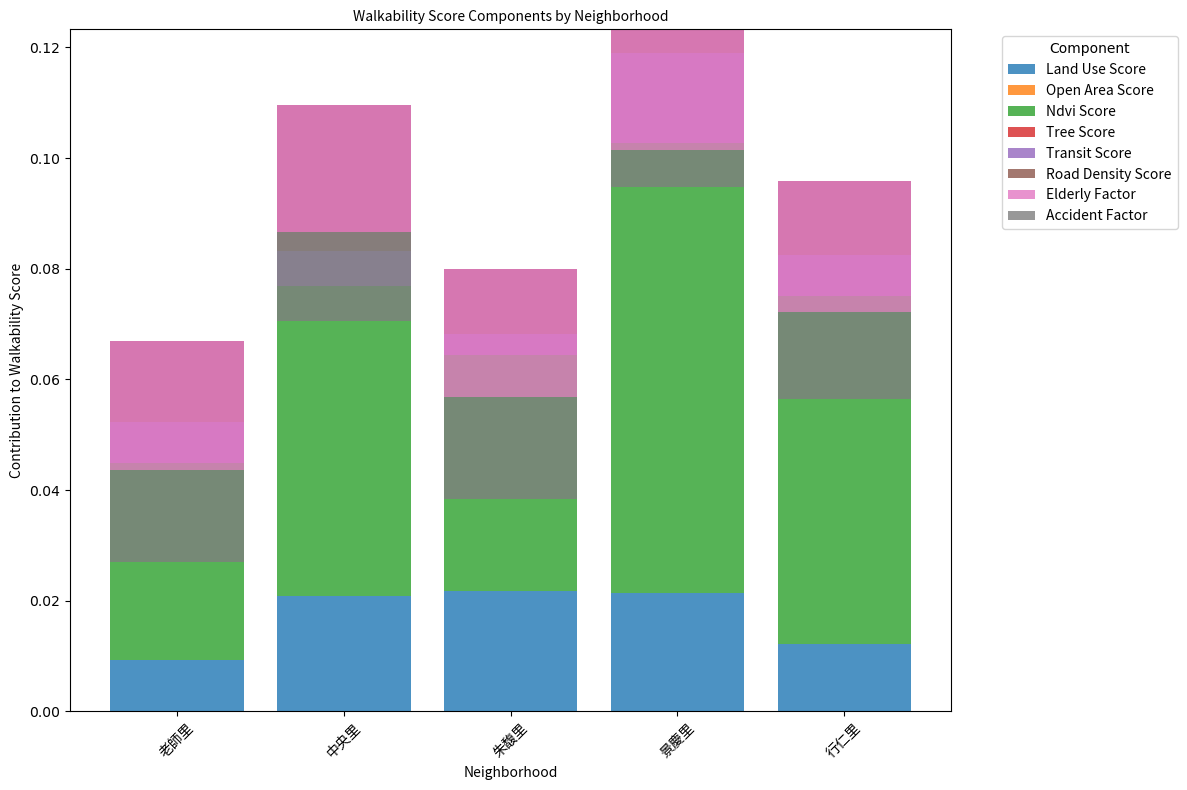

2025-04-13 14:37:53,212 - INFO - Stacked bar chart saved to /home/johnny/Iaacthesis/projects/Geojson/GNN_Read_data/walkability_components_stacked_bar.png
2025-04-13 14:37:53,213 - INFO - Computing walkability components for all neighborhoods for feature importance...
2025-04-13 14:37:53,581 - INFO - Generating feature importance plot for walkability...
/tmp/ipykernel_218643/3874541683.py:595: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


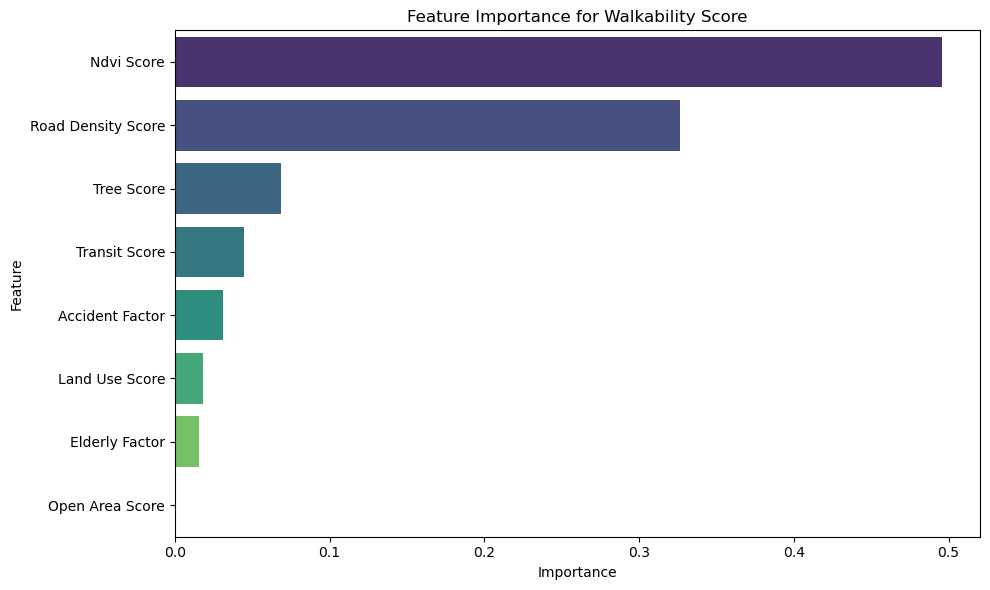

2025-04-13 14:37:53,682 - INFO - Feature importance plot saved to /home/johnny/Iaacthesis/projects/Geojson/GNN_Read_data/walkability_feature_importance.png
2025-04-13 14:37:53,734 - WARNING - Remaining geometry invalid after subtracting Natural in neighborhood 湖田里 (index 0).
2025-04-13 14:37:53,816 - WARNING - Remaining geometry invalid after subtracting Government in neighborhood 大屯里 (index 2).
2025-04-13 14:37:53,835 - WARNING - Remaining geometry invalid after subtracting Natural in neighborhood 平等里 (index 3).
2025-04-13 14:37:53,863 - WARNING - Remaining geometry invalid after subtracting Infrastructure in neighborhood 泉源里 (index 4).
2025-04-13 14:37:54,608 - WARNING - Remaining geometry invalid after subtracting River in neighborhood 溪山里 (index 8).
2025-04-13 14:37:55,370 - WARNING - Remaining geometry invalid after subtracting Special_Zone in neighborhood 中庸里 (index 21).
2025-04-13 14:37:55,563 - WARNING - Remaining geometry invalid after subtracting Natural in neighborhood 溫泉里 (


--- Percentage Calculation Process ---

Neighborhood: 老師里 (Index: 124)
Total unique master plan area: 518211.75 m²
Area of City_Open_Area (priority 10): 11490.41 m²
Area of Education (priority 6): 25808.70 m²
Area of Residential (priority 3): 71638.45 m²
Area of Natural (priority 2): 3873.00 m²
Area of Special_Zone (priority 1): 6873.42 m²
Area of Infrastructure (priority 1): 103405.70 m²
Area of Road (priority 1): 115971.64 m²
Area of River (priority 1): 178142.54 m²
Area of Government (priority 1): 1007.88 m²

Percentages:
City_Open_Area: 2.22%
Education: 4.98%
Residential: 13.82%
Natural: 0.75%
Special_Zone: 1.33%
Infrastructure: 19.95%
Road: 22.38%
River: 34.38%
Government: 0.19%
Sum of percentages: 100.00%

Neighborhood: 中央里 (Index: 30)
Total unique master plan area: 227175.23 m²
Area of City_Open_Area (priority 10): 4484.94 m²
Area of Pedestrian (priority 9): 1021.65 m²
Area of Commercial (priority 4): 38237.98 m²
Area of Residential (priority 3): 78391.81 m²
Area of Natural (pr

2025-04-13 14:38:39,971 - INFO - City graph constructed: 196549 nodes, 275941 edges
2025-04-13 14:38:40,001 - INFO - Stage 3: Calculating rule-based walkability scores...


Finished build_graph
Starting compute_walkability_scores...


2025-04-13 14:38:40,601 - INFO - Preparing GNN data...
2025-04-13 14:38:40,697 - INFO - Number of nodes in nodes_df: 196555
2025-04-13 14:38:40,698 - INFO - Feature columns: ['land_use_residential_percent', 'land_use_commercial_percent', 'land_use_education_percent', 'land_use_city_open_area_percent', 'land_use_public_transportation_percent', 'land_use_pedestrian_percent', 'ndvi_mean', 'tree_count', 'transit_count', 'accident_count', 'road_density', 'total_population', 'elderly_percentage']
2025-04-13 14:38:40,699 - INFO - Shape of nodes_df[feature_cols]: (196555, 13)
2025-04-13 14:38:40,713 - INFO - Shape of input tensor x: torch.Size([196555, 13])


Finished compute_walkability_scores
Starting prepare_gnn_data...


2025-04-13 14:38:41,012 - INFO - Stage 4: Training GNN model...
2025-04-13 14:38:41,110 - INFO - Epoch 1, Loss: 14078520.0000
2025-04-13 14:38:41,198 - INFO - Epoch 2, Loss: 2043934.8750


Finished prepare_gnn_data
Starting train_gnn_model...


2025-04-13 14:38:41,276 - INFO - Epoch 3, Loss: 6093302.0000
2025-04-13 14:38:41,311 - INFO - Epoch 4, Loss: 4479636.5000
2025-04-13 14:38:41,340 - INFO - Epoch 5, Loss: 1090080.5000
2025-04-13 14:38:41,369 - INFO - Epoch 6, Loss: 143443.5781
2025-04-13 14:38:41,398 - INFO - Epoch 7, Loss: 2576460.5000
2025-04-13 14:38:41,426 - INFO - Epoch 8, Loss: 2419339.0000
2025-04-13 14:38:41,456 - INFO - Epoch 9, Loss: 482592.6250
2025-04-13 14:38:41,484 - INFO - Epoch 10, Loss: 87030.4453
2025-04-13 14:38:41,512 - INFO - Epoch 11, Loss: 867044.1250
2025-04-13 14:38:41,541 - INFO - Epoch 12, Loss: 1555301.0000
2025-04-13 14:38:41,569 - INFO - Epoch 13, Loss: 1439336.3750
2025-04-13 14:38:41,597 - INFO - Epoch 14, Loss: 734251.1250
2025-04-13 14:38:41,625 - INFO - Epoch 15, Loss: 120817.8203
2025-04-13 14:38:41,653 - INFO - Epoch 16, Loss: 91587.7734
2025-04-13 14:38:41,682 - INFO - Epoch 17, Loss: 631034.1250
2025-04-13 14:38:41,710 - INFO - Epoch 18, Loss: 878620.1250
2025-04-13 14:38:41,739 - 

Finished train_gnn_model
Starting predict_walkability...


2025-04-13 14:38:47,342 - INFO - Generating interactive Kepler.gl map...


Finished predict_walkability
Starting create_interactive_map...
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


2025-04-13 14:39:23,407 - INFO - Map saved at /home/johnny/Iaacthesis/projects/Geojson/GNN_Read_data/walkability_map.html
2025-04-13 14:39:23,473 - INFO - Processing complete.


Map saved to /home/johnny/Iaacthesis/projects/Geojson/GNN_Read_data/walkability_map.html!
Finished create_interactive_map


In [13]:
def main():
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    os.makedirs(SUBGRAPH_DIR, exist_ok=True)
    logging.info(f"Ensured subgraph directory exists: {SUBGRAPH_DIR}")

    print("Starting load_and_prepare_data...")
    data = load_and_prepare_data()
    print("Finished load_and_prepare_data")

    print("Starting build_graph...")
    G = build_graph(data)
    print("Finished build_graph")

    print("Starting compute_walkability_scores...")
    G = compute_walkability_scores(G)
    print("Finished compute_walkability_scores")

    print("Starting prepare_gnn_data...")
    data_gnn = prepare_gnn_data(G)
    print("Finished prepare_gnn_data")

    print("Starting train_gnn_model...")
    model = train_gnn_model(data_gnn)
    print("Finished train_gnn_model")

    print("Starting predict_walkability...")
    G = predict_walkability(G, model)
    print("Finished predict_walkability")

    print("Starting create_interactive_map...")
    create_interactive_map(G, data)
    print("Finished create_interactive_map")

    logging.info("Processing complete.")

if __name__ == "__main__":
    main()